<a href="https://colab.research.google.com/github/sakasa/notebooks/blob/master/tokyo_covid19_3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import requests
import json
import pandas as pd
import matplotlib.pyplot as plt
import datetime
from pytz import timezone
import numpy as np
import seaborn as sns

%matplotlib inline

### Tokyo COVID19 Data
https://github.com/tokyo-metropolitan-gov/covid19

In [2]:
url = 'https://raw.githubusercontent.com/tokyo-metropolitan-gov/covid19/development/data/data.json'

In [3]:
response = requests.get(url)
print(response)
j_res = json.loads(response.text) # json文字列をdictへ
print(j_res.keys())
j_res['patients_summary']['data'][-15:]

<Response [200]>
dict_keys(['contacts', 'querents', 'patients_summary', 'inspections_summary', 'lastUpdate', 'main_summary'])


[{'小計': 62, '日付': '2021-10-14T08:00:00.000Z'},
 {'小計': 57, '日付': '2021-10-15T08:00:00.000Z'},
 {'小計': 66, '日付': '2021-10-16T08:00:00.000Z'},
 {'小計': 40, '日付': '2021-10-17T08:00:00.000Z'},
 {'小計': 29, '日付': '2021-10-18T08:00:00.000Z'},
 {'小計': 36, '日付': '2021-10-19T08:00:00.000Z'},
 {'小計': 41, '日付': '2021-10-20T08:00:00.000Z'},
 {'小計': 36, '日付': '2021-10-21T08:00:00.000Z'},
 {'小計': 26, '日付': '2021-10-22T08:00:00.000Z'},
 {'小計': 32, '日付': '2021-10-23T08:00:00.000Z'},
 {'小計': 19, '日付': '2021-10-24T08:00:00.000Z'},
 {'小計': 17, '日付': '2021-10-25T08:00:00.000Z'},
 {'小計': 29, '日付': '2021-10-26T08:00:00.000Z'},
 {'小計': 36, '日付': '2021-10-27T08:00:00.000Z'},
 {'小計': 21, '日付': '2021-10-28T08:00:00.000Z'}]

In [4]:
def utc_datestr_to_jst_date(datestr):
  #return datetime.datetime.fromisoformat(datestr.replace('Z', '+00:00')).astimezone(timezone('Asia/Tokyo'))
  # for ~Python3.6
  return datetime.datetime.strptime(datestr.split('.')[0].replace('-', '').replace(':', ''), '%Y%m%dT%H%M%S').astimezone(timezone('Asia/Tokyo'))

In [5]:
keys = ['contacts', 'querents', 'patients_summary']

In [6]:
d = j_res
df = pd.DataFrame()
for key in keys:
  k = f'{key.split("_")[0]}_count'
  for v in d[key].values():
    if type(v) is list:
      index = [_v['日付'] for _v in v]
      tmp_df = pd.DataFrame(_v for _v in v)
      tmp_df.index = [utc_datestr_to_jst_date(dt) for dt in tmp_df['日付']]
      tmp_df[k] = tmp_df['小計']
  df = pd.concat([df, tmp_df[k]], axis=1)
df = df.fillna(0).astype('int64')
df.index = [i for i in df.index]
df['datetime'] = df.index
df

,contacts_count,querents_count,patients_count,datetime
2020-01-24 17:00:00+09:00,0,0,1,2020-01-24 17:00:00+09:00
2020-01-25 17:00:00+09:00,0,0,1,2020-01-25 17:00:00+09:00
2020-01-26 17:00:00+09:00,0,0,0,2020-01-26 17:00:00+09:00
2020-01-27 17:00:00+09:00,0,0,0,2020-01-27 17:00:00+09:00
2020-01-28 17:00:00+09:00,0,0,0,2020-01-28 17:00:00+09:00
...,...,...,...,...
2021-10-24 17:00:00+09:00,74,0,19,2021-10-24 17:00:00+09:00
2021-10-25 17:00:00+09:00,143,0,17,2021-10-25 17:00:00+09:00
2021-10-26 17:00:00+09:00,104,0,29,2021-10-26 17:00:00+09:00
2021-10-27 17:00:00+09:00,86,0,36,2021-10-27 17:00:00+09:00


In [7]:
# 7日移動平均
df1 = df
for key in keys:
  k = key.split('_')[0]
  df1[f'{k}_7d_mov_ave'] = df[f'{k}_count'].rolling('7D').mean()
  # df1[f'{k}_7d_mov_center_ave'] = df[f'{k}_count'].rolling(7, center=True).mean()
  df1[f'{k}_7d_mov_sum'] = df[f'{k}_count'].rolling('7D').sum()
df1.tail()

,contacts_count,querents_count,patients_count,datetime,contacts_7d_mov_ave,contacts_7d_mov_sum,querents_7d_mov_ave,querents_7d_mov_sum,patients_7d_mov_ave,patients_7d_mov_sum
2021-10-24 17:00:00+09:00,74,0,19,2021-10-24 17:00:00+09:00,102.285714,716.0,0.0,0.0,31.285714,219.0
2021-10-25 17:00:00+09:00,143,0,17,2021-10-25 17:00:00+09:00,107.571429,753.0,0.0,0.0,29.571429,207.0
2021-10-26 17:00:00+09:00,104,0,29,2021-10-26 17:00:00+09:00,103.857143,727.0,0.0,0.0,28.571429,200.0
2021-10-27 17:00:00+09:00,86,0,36,2021-10-27 17:00:00+09:00,100.285714,702.0,0.0,0.0,27.857143,195.0
2021-10-28 17:00:00+09:00,0,0,21,2021-10-28 17:00:00+09:00,81.714286,572.0,0.0,0.0,25.714286,180.0


In [8]:
df2 = df1
# 日付が年の何週目かを列にセット `'{yy}w{week nnum}`
df2['week_num'] = [f'\'{d.strftime("%y")}w{d.strftime("%V")}' for d in df1.index]
# 曜日の列をセット
df2['week_day'] = [d.strftime('%a') for d in df1.index]
df2.tail(15)

,contacts_count,querents_count,patients_count,datetime,contacts_7d_mov_ave,contacts_7d_mov_sum,querents_7d_mov_ave,querents_7d_mov_sum,patients_7d_mov_ave,patients_7d_mov_sum,week_num,week_day
2021-10-14 17:00:00+09:00,100,0,62,2021-10-14 17:00:00+09:00,133.142857,932.0,0.0,0.0,77.142857,540.0,'21w41,Thu
2021-10-15 17:00:00+09:00,125,0,57,2021-10-15 17:00:00+09:00,135.285714,947.0,0.0,0.0,65.571429,459.0,'21w41,Fri
2021-10-16 17:00:00+09:00,112,0,66,2021-10-16 17:00:00+09:00,129.857143,909.0,0.0,0.0,63.285714,443.0,'21w41,Sat
2021-10-17 17:00:00+09:00,96,0,40,2021-10-17 17:00:00+09:00,125.571429,879.0,0.0,0.0,60.428571,423.0,'21w41,Sun
2021-10-18 17:00:00+09:00,106,0,29,2021-10-18 17:00:00+09:00,118.714286,831.0,0.0,0.0,57.571429,403.0,'21w42,Mon
2021-10-19 17:00:00+09:00,130,0,36,2021-10-19 17:00:00+09:00,114.000000,798.0,0.0,0.0,51.714286,362.0,'21w42,Tue
2021-10-20 17:00:00+09:00,111,0,41,2021-10-20 17:00:00+09:00,111.428571,780.0,0.0,0.0,47.285714,331.0,'21w42,Wed
2021-10-21 17:00:00+09:00,130,0,36,2021-10-21 17:00:00+09:00,115.714286,810.0,0.0,0.0,43.571429,305.0,'21w42,Thu
2021-10-22 17:00:00+09:00,103,0,26,2021-10-22 17:00:00+09:00,112.571429,788.0,0.0,0.0,39.142857,274.0,'21w42,Fri
2021-10-23 17:00:00+09:00,62,0,32,2021-10-23 17:00:00+09:00,105.428571,738.0,0.0,0.0,34.285714,240.0,'21w42,Sat


In [9]:
# 週毎に集計
groupby_week_num = df2.groupby('week_num', as_index=True)

In [10]:
# 集計結果から平均と合計を取得しデータフレームにセット
patients_week_num_df = pd.DataFrame({
    # 'patients_week_num': df2['week_num'].unique(),
    'patients_week_mean': [m for m in groupby_week_num.agg({'patients_count': 'mean'})['patients_count']], 
    'patients_week_sum': [s for s in groupby_week_num.agg({'patients_count': 'sum'})['patients_count']]
  }, index=[d for d in groupby_week_num.agg({'datetime': 'max'})['datetime']])
patients_week_num_df.tail()

,patients_week_mean,patients_week_sum
2021-10-10 17:00:00+09:00,114.714286,803
2021-10-17 17:00:00+09:00,60.428571,423
2021-10-24 17:00:00+09:00,31.285714,219
2021-10-28 17:00:00+09:00,25.750000,103
2021-01-03 17:00:00+09:00,816.000000,2448


In [11]:
df3 = pd.concat([
                df2,
                patients_week_num_df.loc[:, ['patients_week_mean', 'patients_week_sum']]
                ], axis=1)
df3.tail(15)

,contacts_count,querents_count,patients_count,datetime,contacts_7d_mov_ave,contacts_7d_mov_sum,querents_7d_mov_ave,querents_7d_mov_sum,patients_7d_mov_ave,patients_7d_mov_sum,week_num,week_day,patients_week_mean,patients_week_sum
2021-10-14 17:00:00+09:00,100,0,62,2021-10-14 17:00:00+09:00,133.142857,932.0,0.0,0.0,77.142857,540.0,'21w41,Thu,NaN,NaN
2021-10-15 17:00:00+09:00,125,0,57,2021-10-15 17:00:00+09:00,135.285714,947.0,0.0,0.0,65.571429,459.0,'21w41,Fri,NaN,NaN
2021-10-16 17:00:00+09:00,112,0,66,2021-10-16 17:00:00+09:00,129.857143,909.0,0.0,0.0,63.285714,443.0,'21w41,Sat,NaN,NaN
2021-10-17 17:00:00+09:00,96,0,40,2021-10-17 17:00:00+09:00,125.571429,879.0,0.0,0.0,60.428571,423.0,'21w41,Sun,60.428571,423.0
2021-10-18 17:00:00+09:00,106,0,29,2021-10-18 17:00:00+09:00,118.714286,831.0,0.0,0.0,57.571429,403.0,'21w42,Mon,NaN,NaN
2021-10-19 17:00:00+09:00,130,0,36,2021-10-19 17:00:00+09:00,114.000000,798.0,0.0,0.0,51.714286,362.0,'21w42,Tue,NaN,NaN
2021-10-20 17:00:00+09:00,111,0,41,2021-10-20 17:00:00+09:00,111.428571,780.0,0.0,0.0,47.285714,331.0,'21w42,Wed,NaN,NaN
2021-10-21 17:00:00+09:00,130,0,36,2021-10-21 17:00:00+09:00,115.714286,810.0,0.0,0.0,43.571429,305.0,'21w42,Thu,NaN,NaN
2021-10-22 17:00:00+09:00,103,0,26,2021-10-22 17:00:00+09:00,112.571429,788.0,0.0,0.0,39.142857,274.0,'21w42,Fri,NaN,NaN
2021-10-23 17:00:00+09:00,62,0,32,2021-10-23 17:00:00+09:00,105.428571,738.0,0.0,0.0,34.285714,240.0,'21w42,Sat,NaN,NaN


### グラフ出力

In [12]:
sns.set()
sns.set_style('whitegrid')

In [13]:
### 日毎の数
x = df3.index
y1_1 = df3['patients_count']
y1_2 = df3['patients_7d_mov_ave']
#y1_3 = df3['patients_7d_mov_center_ave']
# y1_4 = df3['patients_week_mean']

In [14]:
### 週毎の数
# y2_1 = df3['patients_7d_mov_sum']
# y2_2 = df3['patients_week_sum']

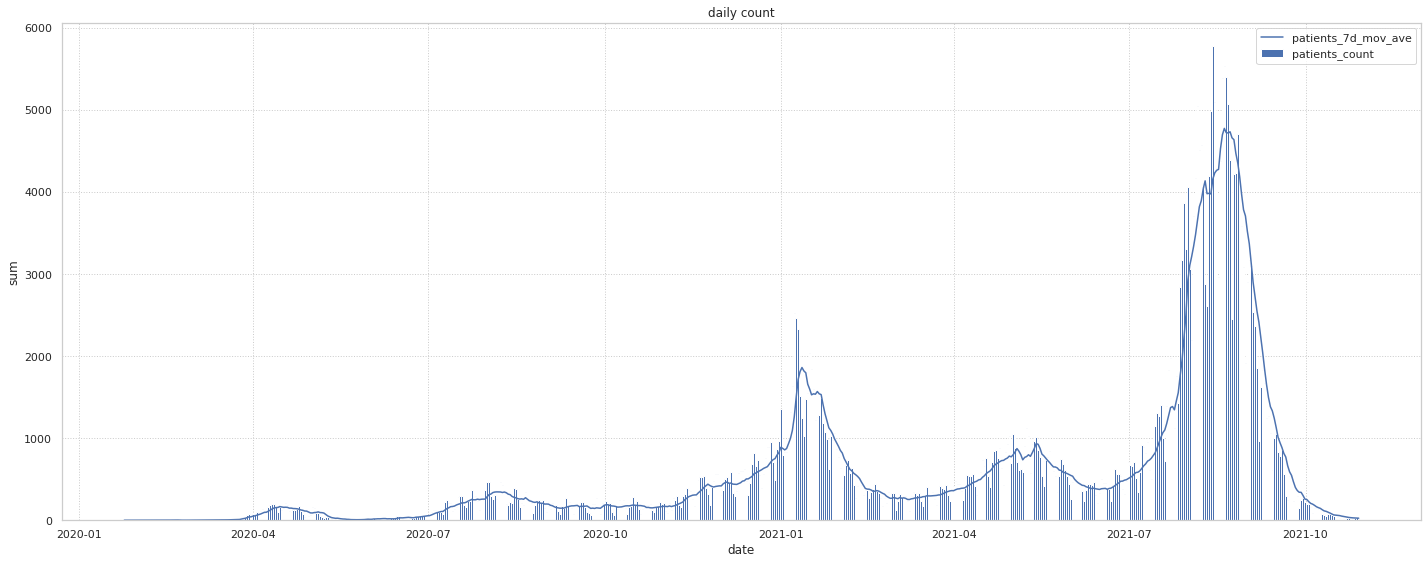

In [15]:
fig, ax = plt.subplots(1,1, figsize=(20, 8))

### 日毎の数
ax.set_title('daily count')
ax.set_xlabel('date')
ax.set_ylabel('sum')
ax.bar(x, y1_1, label='patients_count')
ax.plot(x, y1_2, label='patients_7d_mov_ave')
#ax[0].plot(x, y1_3, label='patients_7d_mov_center_ave')
# ax[0].bar(x, y1_4, label='patients_week_mean')
ax.grid(linestyle=':')
ax.legend()

# ### 週毎の合計
# ax[1].set_title('weekly count')
# ax[1].set_xlabel('date')
# ax[1].set_ylabel('sum')
# ax[1].plot(x, y2_1, label='patients_7d_mov_sum')
# ax[1].bar(x, y2_2, label='patients_week_sum')
# ax[1].grid(linestyle=':')
# ax[1].legend()

plt.tight_layout()

---

In [16]:
def get_date(d: datetime) -> datetime:
  """時間が入った `datetime` を `%Y-%m-%d 00:00:00` の `datetime` に変換します"""
  return datetime.datetime.strptime(d.strftime('%Y-%m-%d'), '%Y-%m-%d')

In [17]:
em_start = datetime.datetime(2020, 4, 7)
em_end = datetime.datetime(2020, 5, 25)
def em_term() -> list:
  """緊急事態宣言期間の日付のリスト"""
  em_term = []
  for i in range((em_end - em_start).days + 1):
    em_term.append(em_start + datetime.timedelta(i))
  return em_term

In [18]:
def emergency(d: datetime) -> int:
  """緊急事態宣言期間中か"""
  return int(get_date(d) in em_term())

In [19]:
def em_passed(d: datetime) -> int:
  """緊急事態宣言から経過日数"""
  d = get_date(d)
  return (d - em_start).days if em_start < d else 0

In [20]:
ds_df = pd.DataFrame({
    'timestamp': [d.timestamp() for d in df3.index], # タイムスタンプ
    'year': np.array(df3.index.strftime('%Y'), dtype=np.int64), # 年
    'month': np.array(df3.index.strftime('%m'), dtype=np.int64), # 月
    'day': np.array(df3.index.strftime('%d'), dtype=np.int64), # 日
    'week_day': df3['week_day'], # 曜日
})
# 曜日をダミー変数化
ds_df = pd.concat([ds_df, pd.get_dummies(ds_df['week_day'])], axis=1)
ds_df = ds_df.drop(columns=['week_day'])

# 経過日数
# ds_df['passed'] = [(d - df3['datetime'][0]).days for d in df3['datetime']]
ds_df['passed'] = [(d - df3.index[0]).days for d in df3.index]
# 緊急事態宣言期間中
ds_df['emergency'] = [emergency(d) for d in df3.index]
# 緊急事態宣言経過日数
ds_df['em_passed'] = [em_passed(d) for d in df3.index]
for key in keys:
  k = key.split('_')[0]
  # 日毎の数
  ds_df[f'{k}_count'] = df3[f'{k}_count']
  # 7日間移動平均
  ds_df[f'{k}_7d_mov_ave'] = df3[f'{k}_7d_mov_ave']
  #ds_df[f'{k}_7d_mov_center_ave'] = df3[f'{k}_7d_mov_center_ave']
  # 7日間移動合計
  ds_df[f'{k}_7d_mov_sum'] = df3[f'{k}_7d_mov_sum']

# 日毎の数
# ds_df['patients_count'] = df3['patients_count']
# 7日間移動平均
# ds_df['patients_7d_mov_ave'] = df3['patients_7d_mov_ave']
#ds_df['7d_mov_center_ave'] = df3['patients_7d_mov_center_ave']
# 7日間移動合計
# ds_df['patients_7d_mov_sum'] = df3['patients_7d_mov_sum']

ds_df = ds_df.reset_index(drop=True)
ds_df.tail(15)

,timestamp,year,month,day,Fri,Mon,Sat,Sun,Thu,Tue,Wed,passed,emergency,em_passed,contacts_count,contacts_7d_mov_ave,contacts_7d_mov_sum,querents_count,querents_7d_mov_ave,querents_7d_mov_sum,patients_count,patients_7d_mov_ave,patients_7d_mov_sum
629,1.634198e+09,2021,10,14,0,0,0,0,1,0,0,629,0,555,100,133.142857,932.0,0,0.0,0.0,62,77.142857,540.0
630,1.634285e+09,2021,10,15,1,0,0,0,0,0,0,630,0,556,125,135.285714,947.0,0,0.0,0.0,57,65.571429,459.0
631,1.634371e+09,2021,10,16,0,0,1,0,0,0,0,631,0,557,112,129.857143,909.0,0,0.0,0.0,66,63.285714,443.0
632,1.634458e+09,2021,10,17,0,0,0,1,0,0,0,632,0,558,96,125.571429,879.0,0,0.0,0.0,40,60.428571,423.0
633,1.634544e+09,2021,10,18,0,1,0,0,0,0,0,633,0,559,106,118.714286,831.0,0,0.0,0.0,29,57.571429,403.0
634,1.634630e+09,2021,10,19,0,0,0,0,0,1,0,634,0,560,130,114.000000,798.0,0,0.0,0.0,36,51.714286,362.0
635,1.634717e+09,2021,10,20,0,0,0,0,0,0,1,635,0,561,111,111.428571,780.0,0,0.0,0.0,41,47.285714,331.0
636,1.634803e+09,2021,10,21,0,0,0,0,1,0,0,636,0,562,130,115.714286,810.0,0,0.0,0.0,36,43.571429,305.0
637,1.634890e+09,2021,10,22,1,0,0,0,0,0,0,637,0,563,103,112.571429,788.0,0,0.0,0.0,26,39.142857,274.0
638,1.634976e+09,2021,10,23,0,0,1,0,0,0,0,638,0,564,62,105.428571,738.0,0,0.0,0.0,32,34.285714,240.0


In [21]:
ds_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 644 entries, 0 to 643
Data columns (total 23 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   timestamp            644 non-null    float64
 1   year                 644 non-null    int64  
 2   month                644 non-null    int64  
 3   day                  644 non-null    int64  
 4   Fri                  644 non-null    uint8  
 5   Mon                  644 non-null    uint8  
 6   Sat                  644 non-null    uint8  
 7   Sun                  644 non-null    uint8  
 8   Thu                  644 non-null    uint8  
 9   Tue                  644 non-null    uint8  
 10  Wed                  644 non-null    uint8  
 11  passed               644 non-null    int64  
 12  emergency            644 non-null    int64  
 13  em_passed            644 non-null    int64  
 14  contacts_count       644 non-null    int64  
 15  contacts_7d_mov_ave  644 non-null    flo

In [22]:
ds_df.describe()

,timestamp,year,month,day,Fri,Mon,Sat,Sun,Thu,Tue,Wed,passed,emergency,em_passed,contacts_count,contacts_7d_mov_ave,contacts_7d_mov_sum,querents_count,querents_7d_mov_ave,querents_7d_mov_sum,patients_count,patients_7d_mov_ave,patients_7d_mov_sum
count,6.440000e+02,644.000000,644.000000,644.000000,644.000000,644.000000,644.000000,644.000000,644.000000,644.000000,644.000000,644.000000,644.000000,644.000000,644.000000,644.000000,644.000000,644.000000,644.000000,644.000000,644.000000,644.000000,644.000000
mean,1.607630e+09,2020.467391,6.228261,15.804348,0.142857,0.142857,0.142857,0.142857,0.142857,0.142857,0.142857,321.500000,0.076087,251.809006,668.504658,668.176094,4677.226708,572.234472,572.234472,4005.641304,586.212733,586.095896,4102.645963
std,1.607481e+07,0.499323,3.148340,8.816370,0.350199,0.350199,0.350199,0.350199,0.350199,0.350199,0.350199,186.051068,0.265343,179.571104,467.978780,455.702549,3189.926540,826.001355,753.068906,5271.482341,962.790338,929.215066,6504.521438
min,1.579853e+09,2020.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1.593742e+09,2020.000000,4.000000,8.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,160.750000,0.000000,86.750000,354.750000,361.714286,2532.000000,0.000000,0.000000,0.000000,87.000000,105.785714,740.500000
50%,1.607630e+09,2020.000000,6.000000,16.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,321.500000,0.000000,247.500000,517.000000,528.500000,3699.500000,0.000000,0.000000,0.000000,266.500000,277.642857,1943.500000
75%,1.621519e+09,2021.000000,9.000000,23.250000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,482.250000,0.000000,408.250000,796.000000,799.107143,5593.750000,1165.500000,1177.250000,8240.750000,593.750000,604.178571,4229.250000
max,1.635408e+09,2021.000000,12.000000,31.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,643.000000,1.000000,569.000000,2265.000000,2096.857143,14678.000000,4060.000000,2574.142857,18019.000000,5773.000000,4774.428571,33421.000000


In [23]:
ds_df.corr()

,timestamp,year,month,day,Fri,Mon,Sat,Sun,Thu,Tue,Wed,passed,emergency,em_passed,contacts_count,contacts_7d_mov_ave,contacts_7d_mov_sum,querents_count,querents_7d_mov_ave,querents_7d_mov_sum,patients_count,patients_7d_mov_ave,patients_7d_mov_sum
timestamp,1.000000e+00,8.641827e-01,2.962986e-01,0.010903,-6.587959e-03,-6.689622e-18,-4.391973e-03,-2.195986e-03,6.587959e-03,2.195986e-03,4.391973e-03,1.000000e+00,-3.450026e-01,0.997699,-0.174982,-0.157268,-0.157265,-0.605295,-6.516447e-01,-6.516447e-01,0.498242,0.526200,0.526205
year,8.641827e-01,1.000000e+00,-2.223009e-01,-0.024768,-2.962263e-18,-2.962263e-18,-2.962263e-18,-2.962263e-18,-2.962263e-18,-2.962263e-18,-2.962263e-18,8.641827e-01,-2.688288e-01,0.872871,-0.184643,-0.165650,-0.165648,-0.649482,-7.123820e-01,-7.123820e-01,0.455356,0.481360,0.481363
month,2.962986e-01,-2.223009e-01,1.000000e+00,-0.023546,-1.269506e-02,6.577364e-18,-8.463375e-03,-4.231688e-03,1.269506e-02,4.231688e-03,8.463375e-03,2.962986e-01,-1.567230e-01,0.275154,0.014251,0.012436,0.012439,0.061264,9.211666e-02,9.211666e-02,0.100317,0.105240,0.105246
day,1.090347e-02,-2.476790e-02,-2.354583e-02,1.000000,-1.007428e-03,5.037142e-04,-1.007428e-03,-5.037142e-04,1.007428e-03,5.037142e-04,5.037142e-04,1.090347e-02,-3.598592e-03,0.011974,-0.016603,-0.017503,-0.017505,0.002263,-1.018685e-02,-1.018685e-02,0.006170,0.002636,0.002632
Fri,-6.587959e-03,-2.962263e-18,-1.269506e-02,-0.001007,1.000000e+00,-1.666667e-01,-1.666667e-01,-1.666667e-01,-1.666667e-01,-1.666667e-01,-1.666667e-01,-6.587959e-03,-6.503455e-18,-0.006020,-0.014912,-0.000358,-0.000358,0.029336,4.692967e-18,-1.149298e-18,0.030689,-0.000050,-0.000052
Mon,-6.689622e-18,-2.962263e-18,6.577364e-18,0.000504,-1.666667e-01,1.000000e+00,-1.666667e-01,-1.666667e-01,-1.666667e-01,-1.666667e-01,-1.666667e-01,2.374434e-18,-6.619589e-18,-0.000011,0.035174,0.000030,0.000031,0.115993,4.860573e-18,0.000000e+00,-0.094666,-0.000006,-0.000006
Sat,-4.391973e-03,-2.962263e-18,-8.463375e-03,-0.001007,-1.666667e-01,-1.666667e-01,1.000000e+00,-1.666667e-01,-1.666667e-01,-1.666667e-01,-1.666667e-01,-4.391973e-03,-6.619589e-18,-0.004017,0.047510,-0.000272,-0.000271,-0.133892,2.346484e-18,2.298596e-18,0.031418,-0.000029,-0.000030
Sun,-2.195986e-03,-2.962263e-18,-4.231688e-03,-0.000504,-1.666667e-01,-1.666667e-01,-1.666667e-01,1.000000e+00,-1.666667e-01,-1.666667e-01,-1.666667e-01,-2.195986e-03,-6.619589e-18,-0.002014,-0.024364,-0.000169,-0.000168,-0.123360,3.352119e-18,-3.064795e-18,-0.022498,-0.000017,-0.000017
Thu,6.587959e-03,-2.962263e-18,1.269506e-02,0.001007,-1.666667e-01,-1.666667e-01,-1.666667e-01,-1.666667e-01,1.000000e+00,-1.666667e-01,-1.666667e-01,6.587959e-03,-6.735722e-18,0.006048,-0.007985,0.000295,0.000295,0.033841,-3.016907e-18,3.064795e-18,0.053632,0.000051,0.000053
Tue,2.195986e-03,-2.962263e-18,4.231688e-03,0.000504,-1.666667e-01,-1.666667e-01,-1.666667e-01,-1.666667e-01,-1.666667e-01,1.000000e+00,-1.666667e-01,2.195986e-03,-6.735722e-18,0.001993,-0.021526,0.000175,0.000176,0.046277,3.687331e-18,0.000000e+00,-0.020196,0.000013,0.000014


---

In [24]:
ds_df.columns

Index(['timestamp', 'year', 'month', 'day', 'Fri', 'Mon', 'Sat', 'Sun', 'Thu',
       'Tue', 'Wed', 'passed', 'emergency', 'em_passed', 'contacts_count',
       'contacts_7d_mov_ave', 'contacts_7d_mov_sum', 'querents_count',
       'querents_7d_mov_ave', 'querents_7d_mov_sum', 'patients_count',
       'patients_7d_mov_ave', 'patients_7d_mov_sum'],
      dtype='object')

In [25]:
_df = ds_df.copy()
_df = _df.drop(['year', 'month', 'day', 
          'contacts_7d_mov_ave', 'contacts_7d_mov_sum', 
          'querents_7d_mov_ave', 'querents_7d_mov_sum', 
          ], axis=1)
_df

,timestamp,Fri,Mon,Sat,Sun,Thu,Tue,Wed,passed,emergency,em_passed,contacts_count,querents_count,patients_count,patients_7d_mov_ave,patients_7d_mov_sum
0,1.579853e+09,1,0,0,0,0,0,0,0,0,0,0,0,1,1.000000,1.0
1,1.579939e+09,0,0,1,0,0,0,0,1,0,0,0,0,1,1.000000,2.0
2,1.580026e+09,0,0,0,1,0,0,0,2,0,0,0,0,0,0.666667,2.0
3,1.580112e+09,0,1,0,0,0,0,0,3,0,0,0,0,0,0.500000,2.0
4,1.580198e+09,0,0,0,0,0,1,0,4,0,0,0,0,0,0.400000,2.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
639,1.635062e+09,0,0,0,1,0,0,0,639,0,565,74,0,19,31.285714,219.0
640,1.635149e+09,0,1,0,0,0,0,0,640,0,566,143,0,17,29.571429,207.0
641,1.635235e+09,0,0,0,0,0,1,0,641,0,567,104,0,29,28.571429,200.0
642,1.635322e+09,0,0,0,0,0,0,1,642,0,568,86,0,36,27.857143,195.0


In [26]:
_df2 = _df[['timestamp', 'passed', 'emergency', 'patients_count', 'patients_7d_mov_ave', 'patients_7d_mov_sum']]
_df2

,timestamp,passed,emergency,patients_count,patients_7d_mov_ave,patients_7d_mov_sum
0,1.579853e+09,0,0,1,1.000000,1.0
1,1.579939e+09,1,0,1,1.000000,2.0
2,1.580026e+09,2,0,0,0.666667,2.0
3,1.580112e+09,3,0,0,0.500000,2.0
4,1.580198e+09,4,0,0,0.400000,2.0
...,...,...,...,...,...,...
639,1.635062e+09,639,0,19,31.285714,219.0
640,1.635149e+09,640,0,17,29.571429,207.0
641,1.635235e+09,641,0,29,28.571429,200.0
642,1.635322e+09,642,0,36,27.857143,195.0


In [27]:
sns.set(style="ticks", color_codes=True)
#sns.pairplot(data=_df)

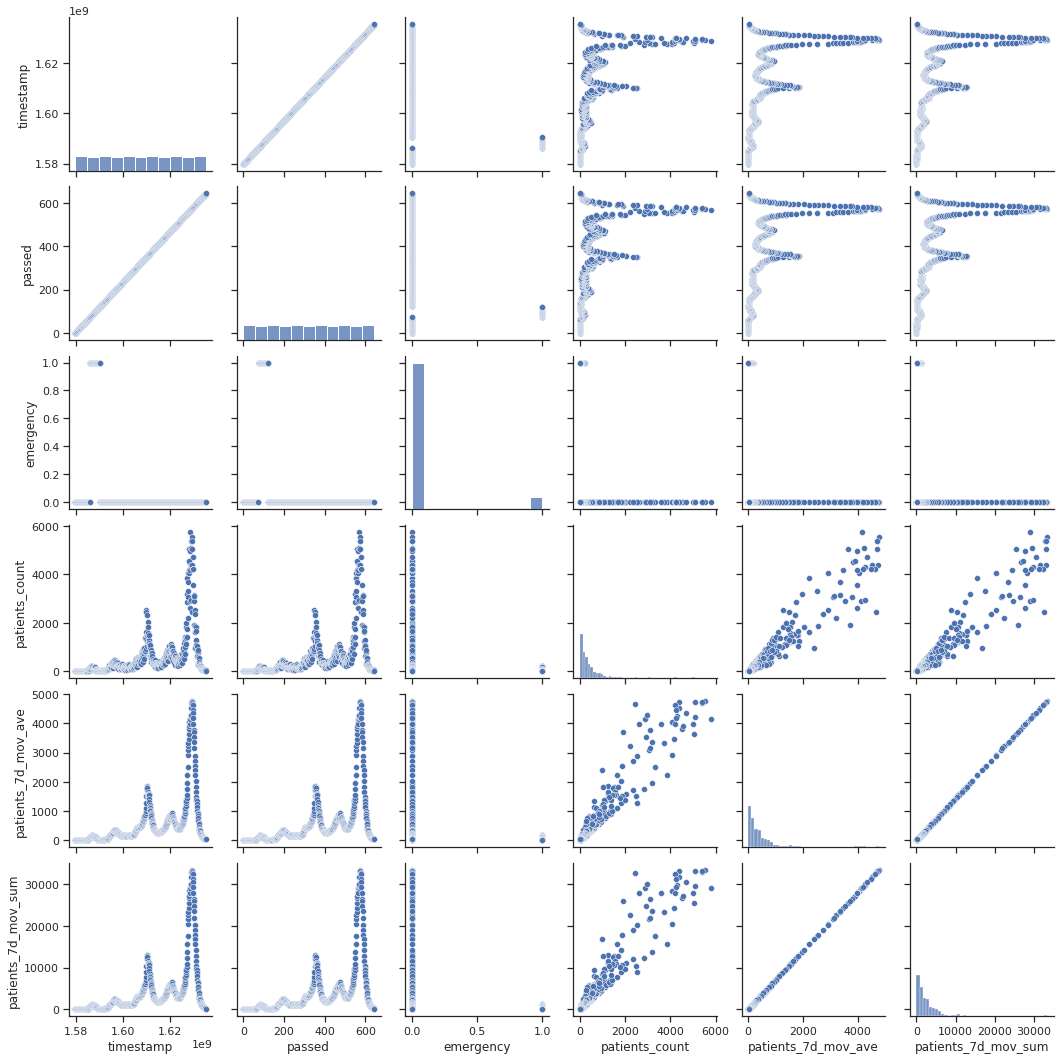

In [28]:
sns.pairplot(data=_df2)

In [29]:
!python -V

Python 3.7.12
